# [머신러닝 기반 시계열 분석 1 실습]
# Decision Tree & k-NN 
# [k-Nearest Neighbor: k-NN Classification - Example 1]

##### jupyter notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)
- 함수 ( ) 안에서 shift+tab: arguments description. shift+tab+tab은 길게 볼 수 있도록

## 1. 모듈 불러오기

import 불러올 패키지명 as 그 패키지를 파이썬에서 사용할 이름

In [ ]:
""" 데이터 전처리 """
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler

""" 모델 생성, 학습, 평가 """
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from sklearn.neighbors import VALID_METRICS
from sklearn.metrics import SCORERS

""" 시각화 """
import seaborn as sns
import matplotlib.pyplot as plt

##  2. Breast Cancer 데이터
- 0-1 scaling 수행
- 데이터 정보: Breast Caner Wisconsin Dataset
    - classses: 2 (malignant: 악성, benign: 정상)
    - sample per class: 50
    - dimensionality: 30 (각 세포들에 대한 정보를 포함)
        - radius: 반경
        - texture: 질감
        - worst~ : 각 세포별 구분들에서 가장 큰 3개의 값을 평균낸 값
        - ~error : 표준오차

In [ ]:
""" 데이터 load """
data = load_breast_cancer()

print(data.feature_names)
print(data.target_names)

In [ ]:
""" 설명변수 및 반은변수 구분 """

X = data.data
y = data.target

In [ ]:
""" 클래스 분포 확인 """
plt.figure(figsize=(4, 5))
sns.countplot(y)
plt.show()

## 2.1. 데이터 전처리

In [ ]:
""" 학습-평가 데이터셋 구성 """
# Train:Test = 80:20
# 클래스 비율 유지: train_test_split 함수 내 stratify 옵션
# randomstate = 2022 

random_state = 2022
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2/10, random_state=random_state, stratify=y)

In [ ]:
# 데이터 스케일링: 0-1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 3. kNN & 최적 파라미터 탐색: Grid Search

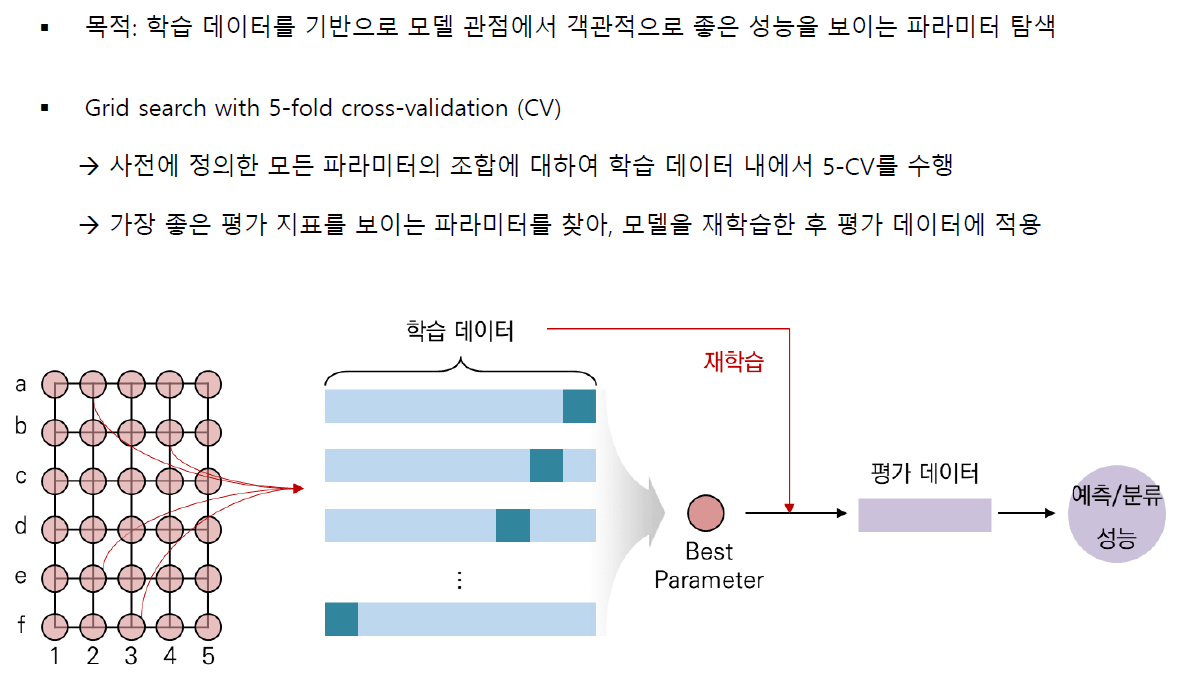

### k-NN Classifier에서 grid search의 대상이 되는 파라미터
- n_neighbors: 근접이웃 개수
- weights: weight for voting
- metric: 거리 계산 방법

In [ ]:
# parameter grid 지정
# dictioanry 안의 list 형태로 넣어서 구성

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['cosine', 'euclidean', 'manhattan']
}

In [ ]:
""" Grid Search CV 모델 구성: cv = 10 """

SCORERS.keys()
model = KNeighborsClassifier()
model_cv = GridSearchCV(estimator=model,
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1)
model_cv.fit(X_train, y_train)

### 필요한 정보 추출
- 파라미터 조합 이름
- 10-CV 성능의 평균 및 표준편차

In [ ]:
results = model_cv.cv_results_
params = results['params']
mean_score = results['mean_test_score']
std_score =results['std_test_score']

In [ ]:
params = ['_'.join(str(x) for x in param.values()) for param in params]
params[:5]

In [ ]:
plt.figure(figsize=(15, 6))
plt.fill_between(range(len(params)), mean_score - std_score, mean_score + std_score, alpha=0.1, color='blue')
plt.plot(range(len(params)), mean_score, color='blue')
plt.ylim([0.7, 1.0])
plt.xticks(range(len(params)), params, rotation=90)
plt.show()

In [ ]:
# Best parameter 출력
print('Best parameters (Grid Search) \n >> ', model_cv.best_params_)

#### Best Model 찾기
1) best parameter를 사용해서 모델을 다시 학습  
2) best_estimator_를 그대로 사용

In [ ]:
model = model_cv.best_estimator_
model

#### 모델 평가 (test)

In [ ]:
# 에측 결과 산출
y_test_pred = model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
cm = pd.DataFrame(cm)

# Accuracy, F1-Score
acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print('- Accuracy (Test) : {:.3}'.format(acc))
print('- F1 score (Test) : {:.3}'.format(f1))

In [ ]:
# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(data=cm, annot=True, annot_kws={'size': 15}, fmt='d', cmap='Blues')
plt.title('Acc = {:.3f} & F1 = {:.3f}'.format(acc, f1))
plt.show()

### 클래스 불균형이 존재할 경우: F1-Score를 사용해서 다시 한번 체크

In [ ]:
model_cv = GridSearchCV(estimator=model,
                        param_grid=param_grid,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1)
model_cv.fit(X_train, y_train)

In [ ]:
print('Best parameters (Grid Search) \n >> ', model_cv.best_params_)

In [ ]:
# Best Model 선정
model = model_cv.best_estimator_
model

#### 모델 평가 (test)

In [ ]:
# 에측 결과 산출
y_test_pred = model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
cm = pd.DataFrame(cm)

# Accuracy, F1-Score
acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print('- Accuracy (Test) : {:.3}'.format(acc))
print('- F1 score (Test) : {:.3}'.format(f1))

In [ ]:
# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(data=cm, annot=True, annot_kws={'size': 15}, fmt='d', cmap='Blues')
plt.title('Acc = {:.3f} & F1 = {:.3f}'.format(acc, f1))
plt.show()

In [ ]:
# 결과 저장
results = model_cv.cv_results_
params = results['params']
mean_score = results['mean_test_score']
std_score =results['std_test_score']

In [ ]:
params = ['_'.join(str(x) for x in param.values()) for param in params]
params[:5]

In [ ]:
plt.figure(figsize=(15, 6))
plt.fill_between(range(len(params)), mean_score - std_score, mean_score + std_score, alpha=0.1, color='blue')
plt.plot(range(len(params)), mean_score, color='blue')
# plt.ylim([0.5, 1.0])
plt.xticks(range(len(params)), params, rotation=90)
plt.show()